In [1]:
from scripts.rmsd import get_coordinates, calculate_rmsd
import py3Dmol
import numpy as np
from rdkit import Chem, Geometry
import re

def show_mol(mol, view, grid):
    mb = Chem.MolToMolBlock(mol)
    view.removeAllModels(viewer=grid)
    view.addModel(mb,'sdf', viewer=grid)
    view.setStyle({'model':0},{'stick': {}}, viewer=grid)
    view.zoomTo(viewer=grid)
    return view

def view_single(mol):
    view = py3Dmol.view(width=480, height=480, linked=False, viewergrid=(1,1))
    show_mol(mol, view, grid=(0, 0))
    return view

def view_two(r_mol, p_mol):
    view = py3Dmol.view(width=480*2, height=480, linked=False, viewergrid=(1,2))
    show_mol(r_mol, view, grid=(0, 0))
    show_mol(p_mol, view, grid=(0, 1))
    view.addPropertyLabels("index", "", {"fontSize": 10})
    return view

def get_smi_syms_coords_from_xyz(_file):
    with open(_file) as f:
        xyz = f.readlines()

    smi = xyz[1].rstrip()
    syms_coords = xyz[2:]
    syms, coords = [], []
    for line in syms_coords:
        data = line.split()
        syms.append(data[0])
        coords.append([float(data[1]), float(data[2]), float(data[3])])
    coords = np.array(coords)
    return smi, syms, coords

def write_product_to_file(ep_mol, smi, n):
    block = Chem.MolToMolBlock(ep_mol.GetMol())
    block = block.split('\n')
    block[0] = smi

    sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
    with open(sdf_file, 'w') as f:
        f.writelines('\n'.join(block))

### try to clean some of the data

reactants

In [ ]:
import glob
import re

error_files = []

for xyz_file in sorted(glob.glob('data/gsm/reactants/*.xyz')):
    
    try:
        n = re.findall(r'\d+', xyz_file)[0]

        with open(xyz_file) as f:
            xyz = f.readlines()
        smiles = xyz[1]

        sdf_file = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
        with open(sdf_file) as f:
            sdf = f.readlines()
        sdf[0] = smiles

        with open(sdf_file, 'w') as f:
            f.writelines(sdf)
            
    except Exception as e:
        error_files.append(xyz_file)
        print(xyz_file, e)

fix errors

In [ ]:
error_file = error_files[7]
with open(error_file) as f:
    xyz = f.readlines()

smi = xyz[1].rstrip()
syms_coords = xyz[2:]
syms, coords = [], []
for line in syms_coords:
    data = line.split()
    syms.append(data[0])
    coords.append([float(data[1]), float(data[2]), float(data[3])])
coords = np.array(coords)

In [ ]:
np.array(coords)

In [ ]:
m = Chem.MolFromSmiles(smi)
m = Chem.AddHs(m)
conformer = Chem.Conformer(len(syms))
m.AddConformer(conformer)
for i, a in enumerate(m.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    m.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))

In [ ]:
block = Chem.MolToMolBlock(m)
block = smi + block
print(block)

In [ ]:
view = py3Dmol.view(width=480, height=480, linked=False, viewergrid=(1,1))
show_mol(m, view, grid=(0, 0))

In [ ]:
n = re.findall(r'\d+', error_file)[0]
sdf_file = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
with open(sdf_file, 'w') as f:
    f.writelines(block)

products

In [ ]:
from rdkit import Chem, Geometry
import numpy as np
import glob
import re

error_files = []

for xyz_file in sorted(glob.glob('data/gsm/products/*.xyz')):
    
    try:
        n = re.findall(r'\d+', xyz_file)[0]

        with open(xyz_file) as f:
            xyz = f.readlines()
        smiles = xyz[1]

        #skip multi products
        if '.' in smiles:
            continue

        sdf_file = 'data/gsm/products_sdf/rxn' + n + 'products.sdf'
        with open(sdf_file) as f:
            sdf = f.readlines()
        sdf[0] = smiles

        if sdf[1] == '\n':
            del sdf[1]

        with open(sdf_file, 'w') as f:
            f.writelines(sdf)
            
    except Exception as e:
        error_files.append(xyz_file)
        print(xyz_file, e)

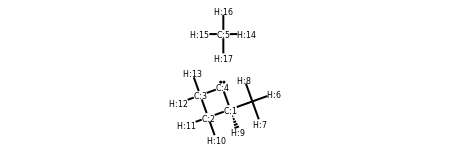

'[C:1]([C@@:2]1([H:10])[C:3]([H:11])([H:12])[C:4]([H:13])([H:14])[C:5]1)([H:7])([H:8])[H:9].[C:6]([H:15])([H:16])([H:17])[H:18]'

In [4]:
# for n=006834
error_file = 'data/gsm/products/rxn006834products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))
[a.SetAtomMapNum(a.GetIdx()) for a in smi_mol.GetAtoms()]
display(smi_mol)
smi

In [3]:
# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# bye CH4
ep_mol.RemoveBond(4, 5)
ep_mol.RemoveBond(4, 14)
ep_mol.AddBond(5, 14, Chem.BondType.SINGLE)


view_two(r_mol, ep_mol.GetMol())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
Chem.SanitizeMol(ep_mol.GetMol())

In [ ]:
print(Chem.MolToMolBlock(ep_mol.GetMol()))

In [ ]:
# for n=013686
error_file = 'data/gsm/products/rxn013686products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# bye CH4
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 10)
ep_mol.AddBond(0, 10, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=006834
error_file = 'data/gsm/products/rxn006834products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# bye CH4
ep_mol.RemoveBond(4, 5)
ep_mol.RemoveBond(4, 14)
ep_mol.AddBond(5, 14, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=003416
error_file = 'data/gsm/products/rxn003416products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# bye CH4
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 8)
ep_mol.AddBond(0, 8, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=001222
error_file = 'data/gsm/products/rxn001222products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# bye H2
ep_mol.RemoveBond(2, 9)
ep_mol.RemoveBond(0, 7)
ep_mol.AddBond(9, 7, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=000938
error_file = 'data/gsm/products/rxn000938products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 7)
ep_mol.AddBond(0, 7, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=023756
error_file = 'data/gsm/products/rxn023756products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycle
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)

ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(1, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=023738
error_file = 'data/gsm/products/rxn023738products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycle
ep_mol.RemoveBond(3, 4)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)
ep_mol.RemoveBond(5, 6)
ep_mol.AddBond(5, 6, Chem.BondType.SINGLE)

ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(3, 6, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=023536
error_file = 'data/gsm/products/rxn023536products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# CH3 transfer
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 5)
ep_mol.AddBond(0, 5, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=023532
error_file = 'data/gsm/products/rxn023532products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(3, 4)
ep_mol.RemoveBond(3, 11)
ep_mol.AddBond(4, 11, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=023528
error_file = 'data/gsm/products/rxn023528products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(6, 13)
ep_mol.AddBond(5, 13, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=022898
error_file = 'data/gsm/products/rxn022898products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# O bridge
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)
ep_mol.RemoveBond(3, 4)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=022838
error_file = 'data/gsm/products/rxn022838products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# C-Cs everywhere
ep_mol.RemoveBond(1, 2)
ep_mol.RemoveBond(1, 5)
ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=022408
error_file = 'data/gsm/products/rxn022408products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(1, 6)
ep_mol.RemoveBond(6, 16)
ep_mol.AddBond(1, 16, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=021556
error_file = 'data/gsm/products/rxn021556products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(3, 4)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)
ep_mol.RemoveBond(3, 9)
ep_mol.AddBond(4, 9, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=021440
error_file = 'data/gsm/products/rxn021440products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# lot going on...this seems wrong lol
ep_mol.RemoveBond(1, 2)
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(1, 2, Chem.BondType.DOUBLE)

Catom = Chem.MolFromSmiles('[C]').GetAtomWithIdx(0)
Catom.SetIsAromatic(False)
Oatom = Chem.MolFromSmiles('[O]').GetAtomWithIdx(0)
Oatom.SetIsAromatic(False)

ep_mol.ReplaceAtom(2, Catom)
ep_mol.ReplaceAtom(3, Catom)
ep_mol.ReplaceAtom(4, Catom)
ep_mol.ReplaceAtom(5, Catom)
ep_mol.ReplaceAtom(6, Oatom)

ep_mol.RemoveBond(2, 6)

ep_mol.RemoveBond(5, 6)
ep_mol.AddBond(5, 6, Chem.BondType.DOUBLE)

ep_mol.AddBond(0, 4, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=020496
error_file = 'data/gsm/products/rxn020496products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycle
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.AddBond(5, 6, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(1, 6, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=019970
error_file = 'data/gsm/products/rxn019970products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycle
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.AddBond(5, 6, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(1, 6, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=019886
error_file = 'data/gsm/products/rxn019886products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# NC transfer
ep_mol.RemoveBond(0, 6)
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)

# charge N
Natom = Chem.MolFromSmiles('[N]').GetAtomWithIdx(0)
Natom.SetFormalCharge(1)
Natom.SetNumRadicalElectrons(0)
ep_mol.ReplaceAtom(0, Natom)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=018806
error_file = 'data/gsm/products/rxn018806products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# N-O
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 6, Chem.BondType.SINGLE)

# charge N
Natom = Chem.MolFromSmiles('[N]').GetAtomWithIdx(0)
Natom.SetFormalCharge(1)
Natom.SetNumRadicalElectrons(0)
ep_mol.ReplaceAtom(6, Natom)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=018030
error_file = 'data/gsm/products/rxn018030products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycle
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(5, 6, Chem.BondType.SINGLE)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 6, Chem.BondType.SINGLE)
ep_mol.AddBond(3, 5, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016912
error_file = 'data/gsm/products/rxn016912products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(6, 14)
ep_mol.RemoveBond(2, 6)
ep_mol.AddBond(2, 14, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016810
error_file = 'data/gsm/products/rxn016810products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# CH3 transfer
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 6)
ep_mol.AddBond(0, 6, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016346
error_file = 'data/gsm/products/rxn016346products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(4, 12)
ep_mol.RemoveBond(2, 4)
ep_mol.AddBond(2, 12, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016338
error_file = 'data/gsm/products/rxn016338products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.RemoveBond(2, 4)
ep_mol.AddBond(4, 10, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016336
error_file = 'data/gsm/products/rxn016336products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(5, 13)
ep_mol.AddBond(6, 13, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=016330
error_file = 'data/gsm/products/rxn016330products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(1, 5)
ep_mol.RemoveBond(5, 13)
ep_mol.AddBond(1, 13, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=014912
error_file = 'data/gsm/products/rxn014912products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 6)
ep_mol.RemoveBond(6, 18)
ep_mol.AddBond(5, 18, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=012898
error_file = 'data/gsm/products/rxn012898products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(4, 6)
ep_mol.RemoveBond(6, 16)
ep_mol.AddBond(4, 16, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=012396
error_file = 'data/gsm/products/rxn012396products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# transfer O-H
ep_mol.RemoveBond(1, 2)
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=011780
error_file = 'data/gsm/products/rxn011780products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# O-Cs
ep_mol.RemoveBond(2, 3)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=011302
error_file = 'data/gsm/products/rxn011302products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# breack C-Cs
ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(1, 2)

# C-C
ep_mol.AddBond(0, 2, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=010420
error_file = 'data/gsm/products/rxn010524products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 13)
ep_mol.AddBond(2, 13, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(2, 5)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=010420
error_file = 'data/gsm/products/rxn010420products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycles!
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=010016
error_file = 'data/gsm/products/rxn010016products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break C-C
ep_mol.RemoveBond(2, 1)

# H transfer
ep_mol.RemoveBond(1, 7)
ep_mol.AddBond(2, 7, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=009522
error_file = 'data/gsm/products/rxn009522products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

smi_mol = Chem.AddHs(Chem.MolFromSmiles(smi))

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# cycles!
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(2, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=009414
error_file = 'data/gsm/products/rxn009414products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(0, 7)
ep_mol.AddBond(3, 7, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=009348
error_file = 'data/gsm/products/rxn009348products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# C-O
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)
ep_mol.AddBond(0, 3, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(3, 5)

# C=C
ep_mol.RemoveBond(5, 1)
ep_mol.AddBond(5, 1, Chem.BondType.DOUBLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=008488
error_file = 'data/gsm/products/rxn008488products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break O-C
ep_mol.RemoveBond(3, 4)

# # H transfer
ep_mol.RemoveBond(3, 11)
ep_mol.AddBond(4, 11, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=007918
error_file = 'data/gsm/products/rxn007918products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(3, 4)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# H tranfser
ep_mol.RemoveBond(1, 10)
ep_mol.AddBond(4, 10, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(1, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=007754
error_file = 'data/gsm/products/rxn007754products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(3, 9)
ep_mol.AddBond(5, 9, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(3, 5)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=007186
error_file = 'data/gsm/products/rxn007186products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# break C-O
ep_mol.RemoveBond(2, 3)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(3, 10, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=006410
error_file = 'data/gsm/products/rxn006410products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# ring!
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(3, 4, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=006198
error_file = 'data/gsm/products/rxn006198products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(1, 10, Chem.BondType.SINGLE)

# # break C-C
ep_mol.RemoveBond(1, 2)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=005806
error_file = 'data/gsm/products/rxn005806products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(5, 15)
ep_mol.AddBond(4, 15, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(4, 5)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=005670
error_file = 'data/gsm/products/rxn005670products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single
ep_mol.RemoveBond(2, 3)
ep_mol.AddBond(2, 3, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(0, 5)
ep_mol.AddBond(3, 5, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(3, 0, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=005484
error_file = 'data/gsm/products/rxn005484products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H shift
ep_mol.RemoveBond(1, 8)
ep_mol.AddBond(5, 8, Chem.BondType.SINGLE)

# remove C-C
ep_mol.RemoveBond(1, 5)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=005434
error_file = 'data/gsm/products/rxn005434products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# # H transfer
ep_mol.RemoveBond(5, 10)
ep_mol.AddBond(3, 10, Chem.BondType.SINGLE)

# break N-C
ep_mol.RemoveBond(3, 5)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=005432
error_file = 'data/gsm/products/rxn005432products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# H transfer
ep_mol.RemoveBond(1, 7)
ep_mol.AddBond(2, 7, Chem.BondType.SINGLE)

# break C-C
ep_mol.RemoveBond(2, 1)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=003650
error_file = 'data/gsm/products/rxn003650products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to single C-C
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# H transfer
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(5, 10, Chem.BondType.SINGLE)

# C-C
ep_mol.AddBond(2, 5, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=002820
error_file = 'data/gsm/products/rxn002820products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# double to single C-O
ep_mol.RemoveBond(1, 2)
ep_mol.AddBond(1, 2, Chem.BondType.SINGLE)
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# add additional C-O
ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)
ep_mol.AddBond(4, 2, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=001486
error_file = 'data/gsm/products/rxn001486products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# triple to double C=N
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.DOUBLE)

# double to single C-O
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)

# # add C-N
ep_mol.AddBond(1, 5, Chem.BondType.SINGLE)

# # add C-O
ep_mol.AddBond(4, 0, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=001334
error_file = 'data/gsm/products/rxn001334products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# replace triple bond wih single
ep_mol.RemoveBond(4, 5)
ep_mol.AddBond(4, 5, Chem.BondType.SINGLE)

# wrong hydrogen bond
ep_mol.RemoveBond(2, 10)
ep_mol.AddBond(5, 10, Chem.BondType.SINGLE)

# C-C bond
ep_mol.AddBond(5, 2, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=001226
error_file = 'data/gsm/products/rxn001226products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

ep_mol.RemoveBond(0, 1)
ep_mol.RemoveBond(0, 6)
ep_mol.AddBond(1, 6, Chem.BondType.SINGLE)

# write to file
write_product_to_file(ep_mol, smi, n)

In [ ]:
# for n=000282
error_file = 'data/gsm/products/rxn000282products.xyz'
smi, syms, coords = get_smi_syms_coords_from_xyz(error_file)

n = re.findall(r'\d+', error_file)[0]
reactant_sdf = 'data/gsm/reactants_sdf/rxn' + n + 'reactants.sdf'
r_mol = Chem.SDMolSupplier(reactant_sdf, removeHs=False)[0]

# make the product by hand
p_mol = Chem.Mol(r_mol)
for i, a in enumerate(p_mol.GetAtoms()):
    assert syms[i] == a.GetSymbol()
    p_mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i][0], coords[i][1], coords[i][2]))
ep_mol = Chem.EditableMol(p_mol)

# single bond to oxygen
ep_mol.RemoveBond(0, 1)
ep_mol.AddBond(0, 1, Chem.BondType.SINGLE)

# correct O-H bond
ep_mol.RemoveBond(5, 9)
ep_mol.AddBond(0, 9, Chem.BondType.SINGLE)

# C=C double bonds
ep_mol.RemoveBond(1, 5)
ep_mol.AddBond(1, 5, Chem.BondType.DOUBLE)

# write to file
write_product_to_file(ep_mol, smi, n)

write all mols to file

In [ ]:
def get_ts_mol(r_mol, p_mol, ts_coords):
    
    # find common bonds between reactant and product
    r_bonds = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in r_mol.GetBonds()]
    r_bonds = [tuple(sorted(b)) for b in r_bonds]
    p_bonds = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in p_mol.GetBonds()]
    p_bonds = [tuple(sorted(b)) for b in p_bonds]
    common_bonds = list(set(r_bonds) & set(p_bonds))
    
    # build ts from reactant and replace xyz coords
    ts_mol = Chem.Mol(r_mol)
    for i in range(ts_mol.GetNumAtoms()):
        ts_mol.GetConformer().SetAtomPosition(
            i, Geometry.Point3D(ts_coords[i][0], ts_coords[i][1], ts_coords[i][2])
        )
    
    # keep common bonds for ts (not really necessary but could be useful later)
#     emol = Chem.EditableMol(ts_mol)
#     for bond in ts_mol.GetBonds():
#         bond_idxs = tuple(sorted((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())))
#         if bond_idxs not in common_bonds:
#             emol.RemoveBond(bond_idxs[0], bond_idxs[1])
    return ts_mol  # emol.GetMol()

In [ ]:
r_sdfs = sorted(glob.glob('data/gsm/reactants_sdf/*.sdf'))
p_sdfs = sorted(glob.glob('data/gsm/products_sdf/*.sdf'))

r_mols, p_mols, ts_mols = [], [], []
for r_sdf, p_sdf in zip(r_sdfs, p_sdfs):
    
    n = re.findall(r'\d+', r_sdf)[0]
    if n == '021440': # skip this one
        continue

    r_mol = Chem.SDMolSupplier(r_sdf, removeHs=False)[0]
    p_mol = Chem.SDMolSupplier(p_sdf, removeHs=False)[0]

    r_smi = Chem.MolToMolBlock(r_mol).split()[0]
    p_smi = Chem.MolToMolBlock(p_mol).split()[0]

    # filter out bimolecular
    if '.' in r_smi or '.' in p_smi:
        continue

    r_mol.UpdatePropertyCache()
    r_mols.append(r_mol)

    p_mol.UpdatePropertyCache()
    p_mols.append(p_mol)
    
    # check syms for ts
    r_syms = [a.GetSymbol() for a in r_mol.GetAtoms()]
    p_syms = [a.GetSymbol() for a in p_mol.GetAtoms()]
    ts_file = 'data/gsm/ts/rxn' + n + 'ts.xyz'
    _, ts_syms, ts_coords = get_smi_syms_coords_from_xyz(ts_file)
    assert r_syms == ts_syms
    assert p_syms == ts_syms
    
    # create ts mol
    ts_mol = get_ts_mol(r_mol, p_mol, ts_coords)
    ts_mols.append(ts_mol)

In [ ]:
# write to files
reactant_writer = Chem.SDWriter('data/intra_gsm_clean/intra_rxns_reactants.sdf')
product_writer = Chem.SDWriter('data/intra_gsm_clean/intra_rxns_products.sdf')
ts_writer = Chem.SDWriter('data/intra_gsm_clean/intra_rxns_ts.sdf')

for i in range(len(r_mols)):
    reactant_writer.write(r_mols[i])
    product_writer.write(p_mols[i])
    ts_writer.write(ts_mols[i])

In [ ]:
# create splits
n = len(r_mols)
split_ids = np.arange(n, dtype=object)
np.random.shuffle(split_ids)
n_test = n//10
n_val = n//10
n_train = n - n_val - n_test
train_ids = split_ids[:n_train]
val_ids = split_ids[n_train:n_train+n_val]
test_ids = split_ids[n_train+n_val:]

In [ ]:
np.save('data/intra_gsm_clean/splits/split0.npy', [train_ids, val_ids, test_ids])